# Analysis Notebook - Count Genes and Events

This notebook processes the raw counts as provided by rMATS and performs some descriptive statistical analysis. It is used to produce the following outputs. 

## Data files created by this notebook
Output text files are written to the ``data/`` directory (at the same level as the ``jupyter`` directory). 

1. **gene_AS.tsv**: Alternative splicing events per gene
2. **Total_AS_by_chr.tsv**: Total alternative splicing events per chromosome
3. **Total_AS_by_geneSymbol.tsv**: Count the number of tissues in which specific genes show significant alternative splicing
4. **Total_AS_by_tissue.tsv**: Count the number of significant splicing events per tissue
5. **Total_AS_by_splicingtype.tsv**: Count number of significant splicing events for each of the 5 alternative splicing categories
6. **Significant_AS_events.tsv**: ?? Counts of significant events per slicing type per tissue
7. **SplicingIndex_chr.tsv**: Splicing index (number of sigificant AS events per 1000 exons)

## Figures (PDF files) created by this notebook
Output PDF Figures are written to the ``pdf/`` directory.

1. **AS_events_per_gene.pdf**: Plot showing genes with the most common AS events across tissues.
2. **tissue-piechart.pdf**: Plot showing number of tissues-per gene with AS events
3. **splicingIndex.pdf**: Plot showing the number of AS events per 1000 exons for each chromosome

In [32]:
defaultW <- getOption("warn")  # suppress warnings for this cell
options(warn = -1) 

library(dplyr)
library(ggplot2)
library(limma)
library(multtest)
library(Biobase)
library(edgeR)
library(tibble)
library(R.utils)
library(rtracklayer)

options(warn = defaultW)

## Download all the rMATS results

Each of the alternative splicing output files are downloaded here:
### 1.2.2 get released rMATS GTF annotations

For each splicing type, the junctions are defined, so we have 5 specific annotated splicing specific junction ID annotation files:

1. **fromGTF.A3SS.txt**: annotations for the alternative 3' splice site junctions
2. **fromGTF.A5SS.txt**: annotations for the alternative 5' splice site junctions
3. **fromGTF.MXE.txt**: annotations for the mutually exclusive exon junctions
4. **fromGTF.RI.txt**: annotations for the retained introns junctions
5. **fromGTF.SE.txt**: annotations for the skipped exon junctions

In [33]:
getReleasedGTFAnnotations <- function ( destDir ) {
    message("Decompressing fromGTF.tar.gz into ../data")
    system("mkdir -p ../data && tar xvfz ../data/fromGTF.tar.gz -C ../data", intern = TRUE)
    message("Done!\n")
    message("Gunzipping files into ../data")
    system("gunzip ../data/fromGTF.*txt.gz", intern = TRUE)
    message("Done!\n")
}

#
# 1.2.2 get the rmats 3.2.5 discovered/annoated junction information in GTF format
#
getReleasedGTFAnnotations (destDir <- "../data/")

Decompressing fromGTF.tar.gz into ../data

Done!


Gunzipping files into ../data

Warning message in system("gunzip ../data/fromGTF.*txt.gz", intern = TRUE):
“running command 'gunzip ../data/fromGTF.*txt.gz' had status 2”
Done!




### 1.2.3 Refined results
We define **refined results* as (FC > 1.5 and pVal < 0.05) for the sex\*as_event coefficient result for the linear model

In [34]:
significant_results_dir = "../data/"
pattern = "DGE_sex_as_events_refined.csv"
files <- list.files(path = significant_results_dir, pattern = pattern)
as_types <- c("a3ss", "a5ss", "mxe", "ri", "se")

In [35]:
a3ss_annot <- read.table(file = "../data/fromGTF.A3SS.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
a5ss_annot <- read.table(file = "../data/fromGTF.A5SS.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
mxe_annot <- read.table(file = "../data/fromGTF.MXE.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
ri_annot <- read.table(file = "../data/fromGTF.RI.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
se_annot <- read.table(file = "../data/fromGTF.SE.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)

In [36]:
message ("\nReading significant events for each splicing factor\n")
gene_as = data.frame()
counts <- rep(NA, length(files))
ASE <- rep("NA", length(files))
Tissue <- rep("NA", length(files))

for (i in 1:length(files)) {
    lines <- read.csv(paste0(significant_results_dir, files[i]),header = TRUE)
    event     <- as.vector(as.character(rownames(lines)))
    tissue <- gsub("_DGE_sex_as_events_refined.csv","", files[i], fixed = TRUE)

    counts[i] <- dim(lines)[1]
    
    if (dim(lines)[1] > 0) { #has significant events
        # rownames of the significant results file are a combination of gene-symbol and junction name
        # using a regular expression - extract the last numbers that then are the index to the annotation table
        event_idx <- substring(event, regexpr("[0-9]+$", event))
        
        if (grepl("a3ss_", files[i])) {
            tissue <- gsub("a3ss_","", tissue, fixed = TRUE)
            ASE[i] <- "A3SS"
            Tissue[i] <- tissue
            idx <- match(event_idx, a3ss_annot$ID)
            res <- data.frame(GeneJunction = event,
                              ASE = "A3SS", 
                              ASE_IDX = idx,
                              Tissue = tissue, 
                              GeneSymbol = a3ss_annot$geneSymbol[idx],
                              chr = a3ss_annot$chr[idx])
        }
        if (grepl("a5ss_", files[i])) {
            tissue <- gsub("a5ss_","", tissue, fixed = TRUE)
            ASE[i] <- "A5SS"
            Tissue[i] <- tissue
            idx <- match(event_idx, a5ss_annot$ID)
            res <- data.frame(GeneJunction = event,
                              ASE = "A5SS", 
                              ASE_IDX = idx,
                              Tissue = tissue, 
                              GeneSymbol = a5ss_annot$geneSymbol[idx],
                              chr = a5ss_annot$chr[idx])
        }
        if (grepl("mxe_", files[i])) {
            ASE[i] <- "MXE"
            tissue <- gsub("mxe_","", tissue, fixed = TRUE)
            Tissue[i] <- tissue
            idx <- match(event_idx, a3ss_annot$ID)
            res <- data.frame(GeneJunction = event,
                              ASE = "MXE", 
                              ASE_IDX = idx,
                              Tissue = tissue, 
                              GeneSymbol = mxe_annot$geneSymbol[idx],
                              chr = mxe_annot$chr[idx])
        }
        if (grepl("se_", files[i])) {
            ASE[i] <- "SE"
            tissue <- gsub("se_","", tissue, fixed = TRUE)
            Tissue[i] <- tissue
            idx <- match(event_idx, se_annot$ID)
            res <- data.frame(GeneJunction = event,
                              ASE = "SE", 
                              ASE_IDX = idx,
                              Tissue = tissue, 
                              GeneSymbol = se_annot$geneSymbol[idx],
                              chr = se_annot$chr[idx])
        }
        if (grepl("ri_", files[i])){
            ASE[i] <- "RI"
            tissue <- gsub("ri_","", tissue, fixed = TRUE)
            Tissue[i] <- tissue
            idx <- match(event_idx, ri_annot$ID)
            res <- data.frame(GeneJunction = event,
                              ASE = "RI", 
                              ASE_IDX = idx,
                              Tissue = tissue, 
                              GeneSymbol = ri_annot$geneSymbol[idx],
                              chr = a3ss_annot$chr[idx])
        }
        gene_as <- rbind(gene_as, res)
        
    } #if has sig. events
    
} #for all files    
message ("\nDone reading significant events!\n")


Reading significant events for each splicing factor



Done reading significant events!




### gene_as.tsv

This file contains (description)
Here is a typical line
<pre>
        GeneJunction    ASE     ASE_IDX Tissue  GeneSymbol      chr
1       MDM4-3553       SE      3553    adipovisceral_omentum   RNPEP   chr1
2       WDR17-8668      SE      8668    adipovisceral_omentum   ANKMY1  chr2
3       IL17RC-5032     SE      5032    adipovisceral_omentum   SNCAIP  chr5
4       DDX3X-5712      A3SS    5712    adrenal_gland   DDX3X   chrX
</pre>
There are 2848 significant events in the file.

In [7]:
glimpse(gene_as)
table(is.na(gene_as$Tissue))
colnames(gene_as)
write.table(gene_as, "../data/gene_as.tsv", quote=FALSE, sep="\t")
head(gene_as)

Observations: 2,848
Variables: 6
$ GeneJunction <fct> MDM4-3553, WDR17-8668, IL17RC-5032, DDX3X-5712, SCO1-845…
$ ASE          <fct> SE, SE, SE, A3SS, A3SS, A3SS, A3SS, A3SS, A3SS, A3SS, A3…
$ ASE_IDX      <int> 3553, 8668, 5032, 5712, 8452, 1493, 5712, 5710, 4891, 45…
$ Tissue       <fct> adipovisceral_omentum, adipovisceral_omentum, adipovisce…
$ GeneSymbol   <fct> RNPEP, ANKMY1, SNCAIP, DDX3X, SCO1, MYO7A, DDX3X, DDX3X,…
$ chr          <fct> chr1, chr2, chr5, chrX, chr17, chr11, chrX, chrX, chr1, …



FALSE 
 2848 

[1] "GeneJunction" "ASE"          "ASE_IDX"      "Tissue"       "GeneSymbol"  
[6] "chr"

,GeneJunction,ASE,ASE_IDX,Tissue,GeneSymbol,chr
,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
1,MDM4-3553,SE,3553,adipovisceral_omentum,RNPEP,chr1
2,WDR17-8668,SE,8668,adipovisceral_omentum,ANKMY1,chr2
3,IL17RC-5032,SE,5032,adipovisceral_omentum,SNCAIP,chr5
4,DDX3X-5712,A3SS,5712,adrenal_gland,DDX3X,chrX
5,SCO1-8452,A3SS,8452,adrenal_gland,SCO1,chr17
6,MYO7A-1493,A3SS,1493,adrenal_gland,MYO7A,chr11


## Tissue specific data frame

In [8]:
sum(Tissue == "NA")
data <- data.frame(Tissue = Tissue, ASE = ASE, Counts = counts)
data <- data[!(Tissue=="NA"),]
head(data)
tail(data)
dim(data)

[1] 79

,Tissue,ASE,Counts
,<fct>,<fct>,<int>
2,adipovisceral_omentum,SE,3
3,adrenal_gland,A3SS,3
4,artery_aorta,A3SS,8
6,artery_tibial,A3SS,1
9,brain_cerebellum,A3SS,1
10,brain_cortex,A3SS,3


,Tissue,ASE,Counts
,<fct>,<fct>,<int>
185,skin_sun_exposed_lower_leg,SE,9
186,small_intestine_terminal_ileum,SE,1
187,spleen,SE,8
188,stomach,SE,9
189,thyroid,SE,45
190,whole_blood,SE,3


[1] 111   3

### Count splicing event by chromosome

Count the number of significant alternative splicing events per chromosome and write to the file **Total_AS_by_chr.tsv**.

In [38]:
res2 <- gene_as          %>% 
       group_by(chr)    %>% 
       count(chr)       %>% 
       arrange(desc(n)) %>% 
       as.data.frame()
res2$chr <- factor(res2$chr, levels = res2$chr)
length(res2$chr)
res2
glimpse(res2)
write.table(res2, file= "../data/Total_AS_by_chr.tsv", sep="\t", quote = FALSE, row.names=F)

[1] 23

chr,n
<fct>,<int>
chr1,244
chrX,236
chr11,194
chr2,187
chr12,168
chr17,166
chr19,163
chr3,163
chr16,139


Observations: 23
Variables: 2
$ chr <fct> chr1, chrX, chr11, chr2, chr12, chr17, chr19, chr3, chr16, chr4, …
$ n   <int> 244, 236, 194, 187, 168, 166, 163, 163, 139, 127, 115, 113, 112, …


###  Count most frequent spliced genes 

In [39]:
res3 <- gene_as %>% 
       group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
res3$GeneSymbol <- factor(res3$GeneSymbol, levels = res3$GeneSymbol)
length(res3$GeneSymbol)
head(res3)
write.table(res3, file = "../data/Total_AS_by_geneSymbol.tsv", sep = "\t", quote=FALSE, row.names = F)

[1] 1678

,GeneSymbol,n
,<fct>,<int>
1,DDX3X,84
2,KDM5C,40
3,ZFX,21
4,SORBS2,18
5,CD44,16
6,CACNB4,12


### Count most frequent splicing by tissue

In [37]:
res4 <- gene_as %>% 
       group_by(Tissue) %>% 
       count(Tissue) %>% 
       arrange(desc(n)) %>% 
       as.data.frame()
res4$Tissue <- factor(res4$Tissue, levels = res4$Tissue)
length(res4$Tissue)
res4
write.table(res4, file = "../data/Total_AS_by_tissue.tsv", sep = "\t", row.names = F)

[1] 38

Tissue,n
<fct>,<int>
breast_mammary_tissue,1788
brain_nucleus_accumbens_basal_ganglia,271
esophagus_muscularis,241
artery_aorta,92
thyroid,52
spleen,40
cells_cultured_fibroblasts,37
muscle_skeletal,31
adiposubcutaneous,26


###  Significant Count by splicing type 
We define **significant** to be FC > 1.5 and pVal < 0.05

Our starting values were the significant events, all meeting the criteria FC > 1.5 and pVal < 0.05


In [12]:
res5 <- gene_as %>% group_by(ASE) %>% count(ASE) %>% arrange(desc(n)) %>% as.data.frame()
res5$ASE <- factor(res5$ASE, levels = res5$ASE)
head(res5)
write.table(res5, file= "../data/Total_AS_by_splicingtype.tsv")

,ASE,n
,<fct>,<int>
1,SE,2109
2,A3SS,229
3,A5SS,202
4,RI,192
5,MXE,116


###  Significant Count by splicing type (significant == FC > 1.5 and pVal < 0.05)

In [13]:
A3SS_keep <- as.character(gene_as$ASE) %in% "A3SS"
table(A3SS_keep)
A3SS.gene_as <- data.frame(gene_as[A3SS_keep == TRUE,])

A5SS_keep <- as.character(gene_as$ASE) %in% "A5SS"
table(A5SS_keep)
A5SS.gene_as <- data.frame(gene_as[A5SS_keep == TRUE,])

MXE_keep  <- as.character(gene_as$ASE) %in% "MXE"
table(MXE_keep)
MXE.gene_as <- data.frame(gene_as[MXE_keep == TRUE,])

SE_keep   <- as.character(gene_as$ASE) %in% "SE"
table(SE_keep)
SE.gene_as <- data.frame(gene_as[SE_keep == TRUE,])

RI_keep   <- as.character(gene_as$ASE) %in% "RI"
table(RI_keep)
RI.gene_as <- data.frame(gene_as[RI_keep == TRUE,])

dim(A3SS.gene_as)
dim(A5SS.gene_as)
dim(MXE.gene_as)
dim(SE.gene_as)
dim(RI.gene_as)


A3SS_keep
FALSE  TRUE 
 2619   229 

A5SS_keep
FALSE  TRUE 
 2646   202 

MXE_keep
FALSE  TRUE 
 2732   116 

SE_keep
FALSE  TRUE 
  739  2109 

RI_keep
FALSE  TRUE 
 2656   192 

[1] 229   6

[1] 202   6

[1] 116   6

[1] 2109    6

[1] 192   6

## Siginficant spliced by Gene for each splicing factor

In [14]:
A3SS.res <- A3SS.gene_as %>% group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
A3SS.res$GeneSymbol <- factor(A3SS.res$GeneSymbol, levels = A3SS.res$GeneSymbol)
message("Significant spliced genes for A3SS\n",
        paste(length(A3SS.res$GeneSymbol)), collapse=" ")
head(A3SS.res)

A5SS.res <- A5SS.gene_as %>% group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
A5SS.res$GeneSymbol <- factor(A5SS.res$GeneSymbol, levels = A5SS.res$GeneSymbol)
message("Significant spliced genes for A5SS\n",
        paste(length(A5SS.res$GeneSymbol)), collapse=" ")
head(A5SS.res)

MXE.res <- MXE.gene_as %>% group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
MXE.res$GeneSymbol <- factor(MXE.res$GeneSymbol, levels = MXE.res$GeneSymbol)
message("Significant spliced genes for MXE\n",
        paste(length(MXE.res$GeneSymbol)), collapse=" ")
head(MXE.res)

RI.res <- RI.gene_as %>% group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
RI.res$GeneSymbol <- factor(RI.res$GeneSymbol, levels = RI.res$GeneSymbol)
message("Significant spliced genes for RI\n",
        paste(length(RI.res$GeneSymbol)), collapse=" ")
head(RI.res)

SE.res <- SE.gene_as %>% group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
SE.res$GeneSymbol <- factor(SE.res$GeneSymbol, levels = SE.res$GeneSymbol)
message("Significant spliced genes for SE\n",
        paste(length(SE.res$GeneSymbol)), collapse=" ")
head(SE.res)

Significant spliced genes for A3SS
185 



,GeneSymbol,n
,<fct>,<int>
1,DDX3X,13
2,HAND2-AS1,7
3,ADGRG1,3
4,PPM1J,3
5,FAIM2,2
6,SLC19A3,2


Significant spliced genes for A5SS
168 



,GeneSymbol,n
,<fct>,<int>
1,DDX3X,22
2,WDR31,4
3,ITGB7,3
4,DEPDC5,2
5,SGCE,2
6,BRD8,2


Significant spliced genes for MXE
84 



,GeneSymbol,n
,<fct>,<int>
1,DDX3X,7
2,SORBS2,5
3,ACSL6,4
4,SGCE,3
5,FAM49B,3
6,AMT,2


Significant spliced genes for RI
160 



,GeneSymbol,n
,<fct>,<int>
1,DDX3X,13
2,HAND2-AS1,3
3,SGCE,3
4,SPG7,3
5,TMEM79,3
6,KDM5B,2


Significant spliced genes for SE
1342 



,GeneSymbol,n
,<fct>,<int>
1,KDM5C,40
2,DDX3X,29
3,ZFX,21
4,CD44,14
5,SORBS2,12
6,CACNB4,11


In [15]:
# Count most frequent spliced genes
res <- gene_as %>% group_by(GeneSymbol) %>% count(GeneSymbol) %>% arrange(desc(n)) %>% as.data.frame()
res$GeneSymbol <- factor(res$GeneSymbol, levels = res$GeneSymbol)
length(res$GeneSymbol)
res2 <- data %>% group_by(Tissue) %>% 
    summarise(Total = sum(Counts)) %>%
    arrange(desc(Total)) %>%
    as.data.frame()

#Add number of tissues
nTissues <- rep(NA, length(res))
for (i in 1:nrow(res)) {
  df_gene <- gene_as %>% filter(GeneSymbol == res$GeneSymbol[i])
  nTissues[i] <- length(unique(df_gene$Tissue))
}
res$Tissues <- nTissues

[1] 1678

## Colors
Let's use the following colors for uniformity

In [16]:
darkblue <- "#3c5488"
red <- "#e64b35"
nearlyblack <- "#040C04"
purple <- "#790079"
orange = "#ff9900"

Saved plot as ../pdf/AS_events_per_gene.pdf



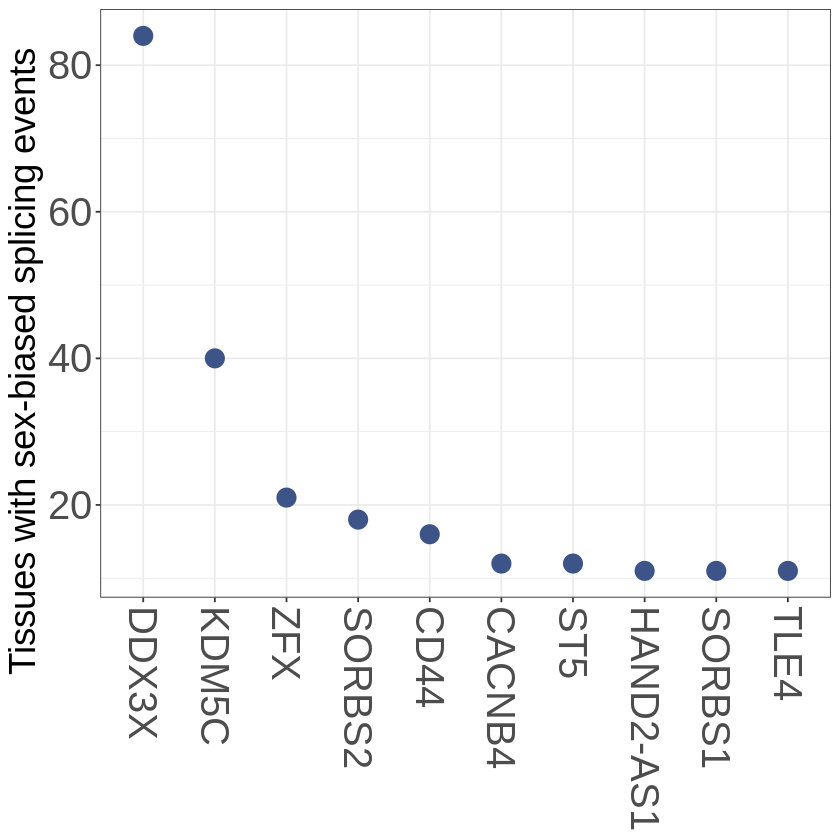

In [19]:
# Genes with more than 10 splicing events
g <- ggplot(res[res$n > 10, ], aes(x = GeneSymbol, y = n)) +
  geom_point(colour = darkblue, size = 5) +
  theme_bw() +
  theme(axis.text.x = element_text(size=24, angle = 270, hjust = 0.0, vjust = 0.5),
        axis.text.y = element_text(size=24),
        axis.title.x = element_blank(),
        axis.title.y = element_text(face="plain", colour="black", 
                                    size=22,hjust=2),
        legend.title=element_blank(),
        legend.position = "none" ) +
  ylab(paste("Tissues with sex-biased splicing events"))
ggsave("../pdf/AS_events_per_gene.pdf",g, height = 4.5, width = 4)
message("Saved plot as ../pdf/AS_events_per_gene.pdf")
g

### Pie chart
Show recurrent vs unique splicing events with a piechart.

Tissue specific 1 tissue
Tissue group 2-5 tissues
Recurrent > 5 tissues

In [20]:
#Pie chart - Number of patients with 0, 1, >1 events
counts <- c(res %>% filter(Tissues == 1) %>% count() %>% as.numeric(),
            res %>% filter(Tissues > 1 & Tissues < 6) %>% count() %>% as.numeric(),
            res %>% filter(Tissues > 5) %>% count() %>% as.numeric())

In [21]:
piecolors <- c(darkblue,red,orange)

Calculate the percentage for each category

In [22]:
counts_labels <- round(counts/sum(counts) * 100, 1)
counts_labels <- paste("(",counts_labels,")", "%", sep="")
counts_labels <- paste(counts, counts_labels,sep =" ")

png 
  2

Wrote file to ../pdf/tissue-piechart.pdf



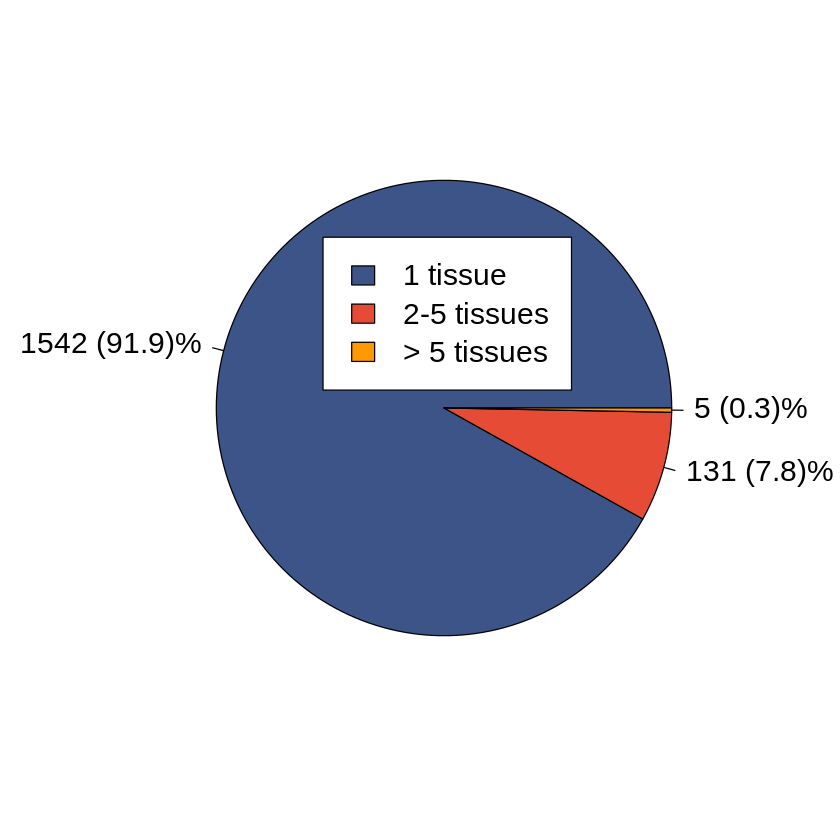

In [24]:
pdf("../pdf/tissue-piechart.pdf")
pie(counts, main="", col=piecolors, labels=counts_labels, cex=1.5)
# Create a legend at the right   
legend(-.425,0.6, c("1 tissue","2-5 tissues","> 5 tissues"), cex=1.5, 
       fill=piecolors, bg="white")
dev.off()
message("Wrote file to ../pdf/tissue-piechart.pdf")
pie(counts, main="", col=piecolors, labels=counts_labels,
    cex=1.5)
# Create a legend at the right   
legend(-.425,0.6, c("1 tissue","2-5 tissues","> 5 tissues"), cex=1.5, 
       fill=piecolors, bg="white")

### Count most frequent spliced chromosomes
To get an indication of which chromosome has the most frequent slicing event (regardless of type)
We create an index based upon the number of exons per chromosome.

get the annotation file, at this writing, gencode.v30.annotation.gtf
The information as to the number of exons within the chromosome may be found there

In [25]:
if (!("GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct" %in% list.files("../data/"))) {
    message("downloading gencode v30 annotation\n")
    system("wget -O ../data/gencode.v30.annotation.gtf.gz ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_30/gencode.v30.annotation.gtf.gz")
    message("Done!\n")
    message("Unzipping compressed file gencode.v30.annotation.gtf.gz..")
    system("gunzip ../data/gencode.v30.annotation.gtf.gz", intern = TRUE)
    message("Done! gencode.v30.annotation.gtf can be found in ../data/")
}
gencode <- import("../data/gencode.v30.annotation.gtf")

downloading gencode v30 annotation


Done!


Unzipping compressed file gencode.v30.annotation.gtf.gz..

Warning message in system("gunzip ../data/gencode.v30.annotation.gtf.gz", intern = TRUE):
“running command 'gunzip ../data/gencode.v30.annotation.gtf.gz' had status 2”
Done! gencode.v30.annotation.gtf can be found in ../data/



In [26]:
exons <- gencode[ gencode$type == "exon", ]
exons <- as.data.frame(exons)

#Obtain chromosomes we have splicing information for (recall we did not use chr Y in our analysis)
all_chr <- as.character(unique(gene_as$chr))
chr_counts <- rep(0, length(all_chr))


for (i in 1:length(all_chr)) {
  chr_counts[i] <- nrow(exons[exons$seqnames == all_chr[i], ])
}

exon_counts <- data.frame(chr = all_chr, counts = chr_counts)

# Count most frequent spliced chromosomes
res <- gene_as %>% group_by(chr) %>% count(chr) %>% arrange(desc(n)) %>% as.data.frame()
res$chr <- factor(res$chr, levels = res$chr)

idx <- match(res$chr, exon_counts$chr)

res$ExonCounts <- exon_counts$counts[idx]

res$Index <- (res$n / res$ExonCounts) * 1000

res_sorted <- res %>% arrange(desc(Index))
res_sorted$chr <- factor(res_sorted$chr, levels = res_sorted$chr)
glimpse(res_sorted)

Observations: 23
Variables: 4
$ chr        <fct> chrX, chr22, chr11, chr4, chr10, chr15, chr12, chr16, chr9…
$ n          <int> 236, 100, 194, 127, 115, 113, 168, 139, 104, 163, 49, 166,…
$ ExonCounts <dbl> 40029, 28655, 75976, 50420, 47124, 47343, 73881, 61199, 46…
$ Index      <dbl> 5.895726, 3.489792, 2.553438, 2.518842, 2.440370, 2.386836…


Saved plot as ../pdf/splicingIndex.pdf



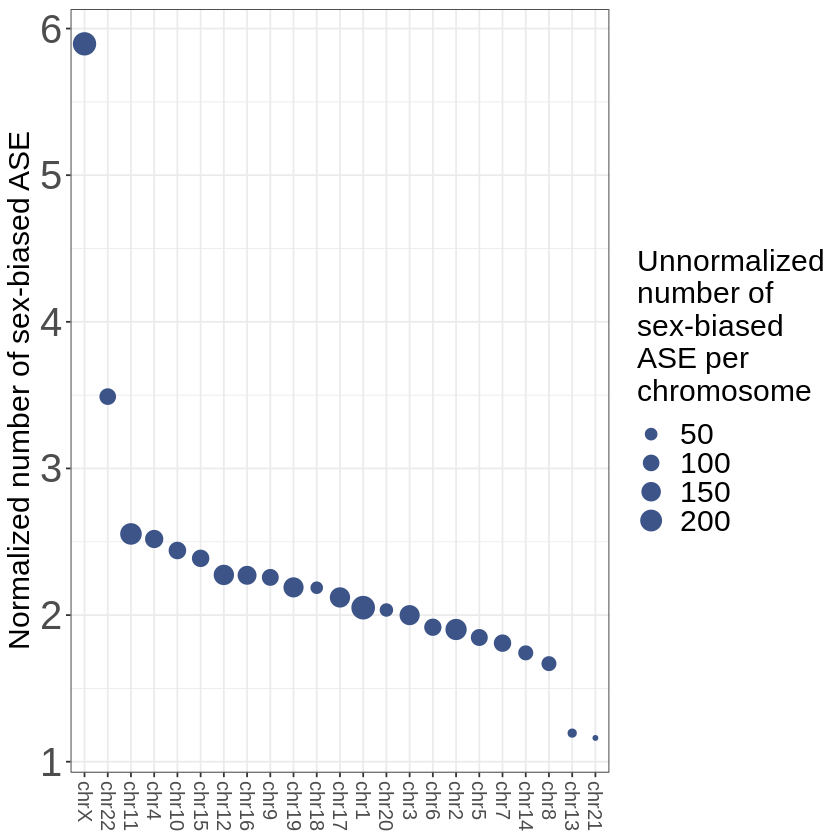

In [27]:
g2 <- ggplot(res_sorted, aes(x = chr, y = Index, size = n)) +
  geom_point(color = darkblue) +
  theme_bw() +
  theme(axis.text.x = element_text(size=12, angle = 270, hjust = 0.0, vjust = 0.5),
        axis.text.y = element_text(size=24),
        axis.title.x = element_blank(),
        axis.title.y = element_text(face="plain", colour="black", 
                                    size=18),
        legend.title=element_text(face="plain", colour="black", 
                                    size=18),
        legend.text = element_text(face="plain", colour="black", 
                                   size=18)) +
  scale_fill_viridis_c(aesthetics = c("colour", "fill"),
                       option = "plasma",
                       limits = c(1, 650)) +
  ylab(paste("Normalized number of sex-biased ASE")) +
  guides(size = guide_legend(title = "Unnormalized\nnumber of\nsex-biased\nASE per\nchromosome"))
ggsave("../pdf/splicingIndex.pdf",g2, height = 4.5, width = 4)
message("Saved plot as ../pdf/splicingIndex.pdf")
g2

In [28]:
write.table(data,       file = "../data/Significant_AS_events.tsv", sep = "\t", row.names = F, quote = F)
write.table(res_sorted, file = "../data/SplicingIndex_chr.tsv", sep = "\t", quote = F, row.names = F)

## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [30]:
rm (notebookid)
notebookid   = "countGenesAndEvents"
notebookid

message("Generating sha256 checksums of the file `../data/Total_AS_by_tissue.tsv` directory .. ")
system(paste0("cd ../data && find . -name SplicingIndex_chr.tsv -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

message("Generating sha256 checksums of the file `../data/Significant_events.tsv` directory .. ")
system(paste0("cd ../data && find . -name SplicingIndex_chr.tsv -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

message("Generating sha256 checksums of the file `../data/Significant_events.tsv` directory .. ")
system(paste0("cd ../data && find . -name SplicingIndex_chr.tsv -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")


paste0("../metadata/", notebookid, "_sha256sums.txt")

data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

[1] "countGenesAndEvents"

Generating sha256 checksums of the file `../data/Totals_by_tissue.tsv` directory .. 



character(0)

Done!


Generating sha256 checksums of the file `../data/Significant_events.tsv` directory .. 



character(0)

Done!


Generating sha256 checksums of the file `../data/Significant_events.tsv` directory .. 



character(0)

Done!




[1] "../metadata/countGenesAndEvents_sha256sums.txt"

sha256sum,file
<chr>,<chr>
6e7812b3bae18c386783dad36a46586c40ed73e8f2fe27b03941e436628be5e8,./SplicingIndex_chr.tsv


### 2. Libraries metadata

In [31]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebookid, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebookid ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..

Done!


Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..

Done!




 setting  value                       
 version  R version 3.6.2 (2019-12-12)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-06-13                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
Biobase,Biobase,2.46.0,2.46.0,/opt/conda/lib/R/library/Biobase,/opt/conda/lib/R/library/Biobase,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
BiocGenerics,BiocGenerics,0.32.0,0.32.0,/opt/conda/lib/R/library/BiocGenerics,/opt/conda/lib/R/library/BiocGenerics,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
dplyr,dplyr,0.8.4,0.8.4,/opt/conda/lib/R/library/dplyr,/opt/conda/lib/R/library/dplyr,TRUE,FALSE,2020-01-31,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.0,3.28.0,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
GenomeInfoDb,GenomeInfoDb,1.22.0,1.22.0,/opt/conda/lib/R/library/GenomeInfoDb,/opt/conda/lib/R/library/GenomeInfoDb,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
GenomicRanges,GenomicRanges,1.38.0,1.38.0,/opt/conda/lib/R/library/GenomicRanges,/opt/conda/lib/R/library/GenomicRanges,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.2.1,3.2.1,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2019-08-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
IRanges,IRanges,2.20.0,2.20.0,/opt/conda/lib/R/library/IRanges,/opt/conda/lib/R/library/IRanges,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
limma,limma,3.42.0,3.42.0,/opt/conda/lib/R/library/limma,/opt/conda/lib/R/library/limma,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
